# Starbucks Capstone

## Loading the Data

Let's load the provided data into some pandas dataframs and gather some basic information about each

In [1]:
import pandas as pd
import numpy as np
import os
import io
import math
import json

import matplotlib.pyplot as plt
% matplotlib inline

import boto3
import sagemaker

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# Let's print some information about each our files
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Data successfully loaded

We've now got a peek of each of our DataFrames which have been read in. Let's gather some exploratory information about the breakdown for a few of the stats.

Income reported:  14825
Income unreported:  2175


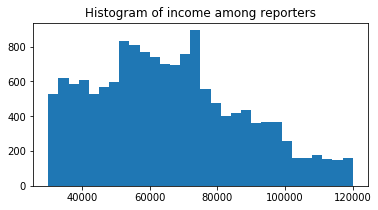

In [5]:
# Plot the income
income_unavailable = sum(pd.isnull(profile['income']))
print('Income reported: ', len(profile) - income_unavailable)
print('Income unreported: ', income_unavailable)

clean_profile = profile.dropna(axis=0)
column_name = 'income'

# Lets see an income breakdown and plot it
ax=plt.subplots(figsize=(6,3))
# get data by column_name and display a histogram
ax = plt.hist(clean_profile[column_name], bins=30)
title=f'Histogram of {column_name} among reporters'
plt.title(title, fontsize=12)
plt.show()
    

age reported:  14825
age unreported:  2175


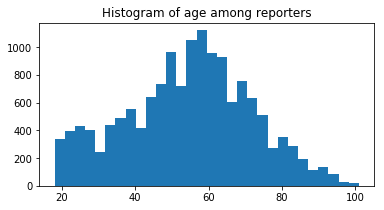

In [6]:
# Plot the income
income_unavailable = len(profile[profile['age'] == 118])
print('age reported: ', len(profile) - income_unavailable)
print('age unreported: ', income_unavailable)

clean_profile = profile.dropna(axis=0)
column_name = 'age'

# Lets see an income breakdown and plot it
ax=plt.subplots(figsize=(6,3))
# get data by column_name and display a histogram
ax = plt.hist(clean_profile[column_name], bins=30)
title=f'Histogram of {column_name} among reporters'
plt.title(title, fontsize=12)
plt.show()

In [7]:
# Let's see our gender breakdown
print('Total: ', len(profile))
print('Women: ', len(profile[profile['gender'] == 'F']))     
print('Men: ', len(profile[profile['gender'] == 'M']))
print('Other: ', len(profile[profile['gender'] == 'O']))
print('None: ', sum(pd.isnull(profile['gender'])))

Total:  17000
Women:  6129
Men:  8484
Other:  212
None:  2175


In [8]:
# Let's see what type events are available
types = transcript.event.unique()
for event in types:
    print(event, '    \t:\t', len(transcript[transcript['event'] == event]))     

offer received     	:	 76277
offer viewed     	:	 57725
transaction     	:	 138953
offer completed     	:	 33579


### Thinking about how to proceed with data pre-processing

At this point, we're ready to start transforming our data in order to maximize the amount of usefulness we'll gain from performing the Principal Component Analysis.

Something we want to be able to continue to referenece is the need for our data to be kept within terms of each customer. In order to do that, we'll have to make some modifications to the profile dataFrame and include various statistics derived from the other data.

In [9]:
def user_stats_df(df):
    # make a new copy of the profile dataframe
    new_df = df
    types = transcript.event.unique()         
    
    event_count_map = { 'offer received': [],
                        'offer viewed': [],
                        'transaction': [],
                        'offer completed': [] }
    
    # Let's take a count of each user's records for each event type
    for index, row in new_df.iterrows():    
        pid = row['id']
        user_events = transcript[transcript['person'] == pid]
    
        for event in types:
            # Add the new column with the calculated values for each event type
            event_count_map[event].append(len(user_events[user_events['event'] == event]))
    
    # Now add each column based on the results above
    new_df['received'] = event_count_map['offer received']
    new_df['viewed'] = event_count_map['offer viewed']
    new_df['transactions'] = event_count_map['transaction']
    new_df['completed'] = event_count_map['offer completed']
    
    return new_df

In [10]:
%%time

result = user_stats_df(profile)

CPU times: user 6min 7s, sys: 1.43 ms, total: 6min 7s
Wall time: 6min 7s


In [11]:
print(len(result))
result.head(10)

17000


,age,became_member_on,gender,id,income,received,viewed,transactions,completed
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,5,5,9,2
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2,0,3,1
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2,2,6,0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,4,7,3
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,5,3,3,0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,4,3,3,2
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,5,5,0,0
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN,5,4,2,0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,6,6,3,5
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN,4,3,6,1


In [12]:
## TODO

# 1) Convert membership date to age

# 2) need an offer df? columns: id, person, number_of views, initial_time_to_view, time_to_complete
#    avg_response_time add a column for avg offer age when viewed (time(viewed) - time(recieved))
#    avg_completion_time for avg offer age when completed (time(completed) - time(viewed))


# Drop a few columns
We can drop a couple things. Firstly, we no longer need the id as it cannot be normalized and we no longer have a use for it. Secondly, for our early model, lets drop any users who haven't reported their age - this is manifested by a reported age of '118'

In [13]:
df = profile[profile['age'] != 118]
print(f'Size after dropping unreported age: {len(df)}')

# TODO Turn gender into a 0123 class so it doesnt need to be dropped
clean_df = df.drop(['id','gender'], 1)
print('Dropped id column')
clean_df.head()

Size after dropping unreported age: 14825
Dropped id column


,age,became_member_on,income,received,viewed,transactions,completed
1,55,20170715,112000.0,2,0,3,1
3,75,20170509,100000.0,4,4,7,3
5,68,20180426,70000.0,4,3,3,2
8,65,20180209,53000.0,6,6,3,5
12,58,20171111,51000.0,3,2,4,1


## Normalize the data we've got

In [14]:
# scale numerical features into a normalized range, 0-1

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
# store them in this dataframe
df_scaled=pd.DataFrame(scaler.fit_transform(clean_df.astype(float)))

# get same features and profile indices
df_scaled.columns=clean_df.columns
df_scaled.index=clean_df.index

df_scaled.head()

,age,became_member_on,income,received,viewed,transactions,completed
1,0.445783,0.799768,0.911111,0.333333,0.000000,0.083333,0.166667
3,0.686747,0.795648,0.777778,0.666667,0.666667,0.194444,0.500000
5,0.602410,0.994000,0.444444,0.666667,0.500000,0.083333,0.333333
8,0.566265,0.989659,0.255556,1.000000,1.000000,0.083333,0.833333
12,0.481928,0.807688,0.233333,0.500000,0.333333,0.111111,0.166667


In [15]:
df_scaled.describe()

,age,became_member_on,income,received,viewed,transactions,completed
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.438476,0.723206,0.393389,0.747622,0.560540,0.232260,0.364744
std,0.209442,0.237727,0.239981,0.179116,0.215219,0.143963,0.263699
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.289157,0.595856,0.211111,0.666667,0.333333,0.111111,0.166667
50%,0.445783,0.801508,0.377778,0.833333,0.500000,0.194444,0.333333
75%,0.578313,0.810069,0.555556,0.833333,0.666667,0.305556,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::504181231539:role/service-role/AmazonSageMaker-ExecutionRole-20191207T194678


In [17]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-west-2-504181231539



In [18]:
# define location to store model artifacts
prefix = 'customer_profiles'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-west-2-504181231539/customer_profiles/


In [19]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS=6

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


In [20]:
# convert df to np array
train_data_np = df_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

In [21]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

2020-01-07 10:47:05 Starting - Starting the training job...
2020-01-07 10:47:06 Starting - Launching requested ML instances...
2020-01-07 10:48:06 Starting - Preparing the instances for training.........
2020-01-07 10:49:36 Downloading - Downloading input data...
2020-01-07 10:50:06 Training - Training image download completed. Training in progress.
2020-01-07 10:50:06 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
[01/07/2020 10:50:03 INFO 140248872220480] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[01/07/2020 10:50:03 INFO 140248872220480] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'7', u

In [23]:
training_job_name = 'pca-2020-01-07-10-47-05-733' ## NEEDS TO BE UPDATED MANUALLY

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

customer_profiles/pca-2020-01-07-10-47-05-733/output/model.tar.gz


2304

In [24]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[15.239724 21.475235 22.869556 29.60583  32.078278 39.67358 ]
<NDArray 6 @cpu(0)>, 'v': 
[[-0.01583034  0.39382285 -0.76591986  0.0771102   0.47673208 -0.14290868]
 [ 0.04318594  0.35415134  0.2390176  -0.7897609   0.2751553   0.27507117]
 [-0.00241483 -0.43343136  0.32458347  0.12663212  0.73843086 -0.2845045 ]
 [-0.80095077 -0.27320808 -0.19607466 -0.35925323 -0.1568353  -0.29017207]
 [ 0.58749354 -0.39349827 -0.28960562 -0.45317677 -0.16568832 -0.42355412]
 [ 0.10194167  0.16859125  0.0163027   0.14073092 -0.31332368 -0.18723224]
 [-0.02855969  0.5231741   0.35819054  0.00766912 -0.03891369 -0.7240969 ]]
<NDArray 7x6 @cpu(0)>, 'mean': 
[[0.43847623 0.72320634 0.39338878 0.7476223  0.5605397  0.23225969
  0.36474425]]
<NDArray 1x7 @cpu(0)>}


In [25]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [26]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[start_idx:, :])

           0
1  21.475235
2  22.869556
3  29.605829
4  32.078278
5  39.673580


In [27]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [28]:
# test cell
n_top_components = 4 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.8523339


In [29]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in profile dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

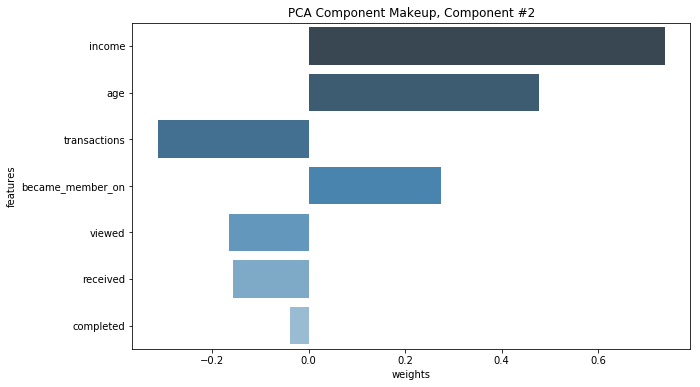

In [30]:
# display makeup of first component
num=2
display_component(v, df_scaled.columns.values, component_num=num, n_weights=10)

In [31]:
%%time

## DEPLOY THE PCA MODEL

# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

-------------------------------------------------------------------------------------------------------------!CPU times: user 555 ms, sys: 48.8 ms, total: 604 ms
Wall time: 9min 10s


In [32]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

In [33]:
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: -0.005072668194770813
      values: 0.010616712272167206
      values: 0.35093677043914795
      values: 0.38603895902633667
      values: 0.6190720796585083
      values: 0.4016664922237396
    }
  }
}



In [34]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, profiles_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by User Profile and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param profiles_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by Profile, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    profiles_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        profiles_transformed=profiles_transformed.append([list(components)])

    # index by profile, just like profiles_scaled
    profiles_transformed.index=profiles_scaled.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    profiles_transformed = profiles_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return profiles_transformed.iloc[:, ::-1]

In [35]:
# specify top n
top_n = 4

# call your function and create a new dataframe
pf_transformed = create_transformed_df(train_pca, df_scaled, n_top_components=top_n)

# add descriptive columns
PCA_list=[]

for i in range(top_n):
    PCA_list.append(f'c_{i}')

pf_transformed.columns=PCA_list 

# print result
pf_transformed.head()

,c_0,c_1,c_2,c_3
1,0.401666,0.619072,0.386039,0.350937
3,-0.237231,0.423834,-0.012686,-0.015105
5,0.136296,0.260976,-0.159436,-0.024537
8,-0.476543,-0.051511,-0.525220,-0.090266
12,0.396763,0.047919,0.089717,-0.023611


In [36]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

In [37]:
### K-MEANS model

# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 6

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)


In [38]:
# convert the transformed dataframe into record_set data
kmeans_train_data_np = pf_transformed.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

In [39]:
%%time
# train kmeans
kmeans.fit(kmeans_formatted_data)

2020-01-07 11:01:18 Starting - Starting the training job...
2020-01-07 11:01:19 Starting - Launching requested ML instances......
2020-01-07 11:02:20 Starting - Preparing the instances for training......
2020-01-07 11:03:33 Downloading - Downloading input data...
2020-01-07 11:04:14 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[01/07/2020 11:04:17 INFO 139807211136832] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]'

In [40]:
%%time
# deploy the model to create a predictor
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

--------------------------------------------------------------------------------------------------------------------------------------!CPU times: user 662 ms, sys: 16.5 ms, total: 679 ms
Wall time: 11min 15s


In [41]:
# get the predicted clusters for all the kmeans training data
cluster_info=kmeans_predictor.predict(kmeans_train_data_np)

In [42]:
# print cluster info for first data point
data_idx = 0

print('user is: ', pf_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

user is:  1

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.6251247525215149
    }
  }
}



In [43]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

In [44]:
# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

2.0    3216
4.0    2917
0.0    2446
3.0    2341
5.0    1999
1.0    1906
Name: 0, dtype: int64


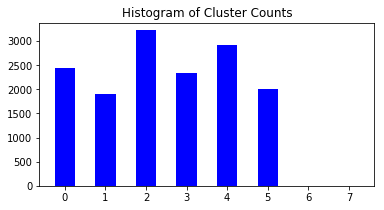

In [45]:
# another method of visualizing the distribution
# display a histogram of cluster counts
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=8,  range=(-0.5, 7.5), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

In [46]:
# delete kmeans endpoint
session.delete_endpoint(kmeans_predictor.endpoint)

In [47]:
#can be found under 'training jobs' in sagemaker menu
kmeans_job_name = 'kmeans-2020-01-07-11-01-18-320'

model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')

# download the model file
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [48]:
# get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

print(kmeans_model_params)

[
[[-0.00550722  0.3401874   0.15049902  0.04805914]
 [-0.0933059  -0.28199098 -0.14350016  0.14991622]
 [ 0.4068285  -0.06289279 -0.09216513  0.01314913]
 [ 0.02513019  0.12939458 -0.18369527 -0.1153675 ]
 [-0.4148865   0.01936819 -0.01906813  0.01408211]
 [ 0.02535332 -0.23148814  0.33938846 -0.072523  ]]
<NDArray 6x4 @cpu(0)>]


In [50]:
# get all the centroids
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns=pf_transformed.columns

display(cluster_centroids)

,c_0,c_1,c_2,c_3
0,-0.005507,0.340187,0.150499,0.048059
1,-0.093306,-0.281991,-0.143500,0.149916
2,0.406828,-0.062893,-0.092165,0.013149
3,0.025130,0.129395,-0.183695,-0.115368
4,-0.414887,0.019368,-0.019068,0.014082
5,0.025353,-0.231488,0.339388,-0.072523


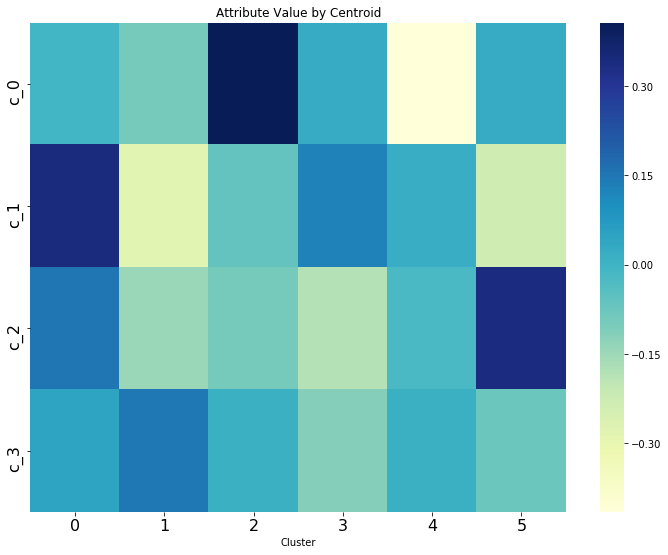

In [51]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

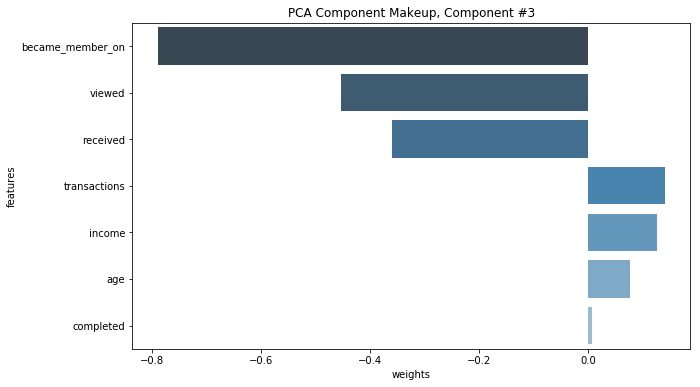

In [53]:
# what do each of these components mean again?
# let's use the display function, from above
component_num=3
display_component(v, df_scaled.columns.values, component_num=component_num)

In [56]:
# add a 'labels' column to the dataframe
pf_transformed['labels']=list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_profiles = pf_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_profiles.head(20)

,c_0,c_1,c_2,c_3,labels
1,0.401666,0.619072,0.386039,0.350937,0
7184,0.242254,0.487633,-0.077766,0.006610,0
7187,-0.294783,0.327783,0.138536,0.229833,0
7199,-0.196436,0.407521,0.122610,0.301531,0
7200,-0.032990,0.595037,0.584006,0.057386,0
7210,-0.063941,0.184585,0.012316,0.123182,0
7220,-0.336512,0.414338,-0.043913,0.187745,0
7224,-0.159963,0.292399,0.109859,0.219701,0
7227,0.077386,0.347820,0.072486,0.122909,0
7234,0.225407,0.112074,0.210724,0.208650,0


In [58]:
# get all profiles with label == 1
cluster=pf_transformed[pf_transformed['labels']==2]
cluster.head()

,c_0,c_1,c_2,c_3,labels
12,0.396763,0.047919,0.089717,-0.023611,2
18,0.270379,-0.079564,0.039104,-0.002754,2
19,0.583112,0.006950,-0.060850,-0.104416,2
27,0.193946,-0.238038,-0.164790,0.065769,2
28,0.549551,0.077602,0.095632,0.069552,2
